In [22]:
import json
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import  LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pq.read_table(source='D:/mashob/data/finally/lemmatized_texts.parquet').to_pandas()

In [3]:
df.head(3)

,id,title,text_markdown,timestamp,author_id,username,rating,pluses,minuses,url,tags
7,2936217,рассада,аня волос нос расти петя аня мочь жопа рассада...,1419527068,453525,Misochkin,-9,5,14,https://pikabu.ru/story/rassada_2936217,"[Петр, Анна, Рассада, Волосы, Текст, Переписка..."
11,6991412,начальник обед,недавно родственница жаловаться дурдом работа ...,1571215335,1699826,FluffyMagpie,641,681,40,https://pikabu.ru/story/pro_nachalnikov_i_obed...,"[Начальник, Руководитель, Обед, Еда, Сотрудник..."
15,6991359,помогать пожалуйста поиск игра,добрый время сутки господин дама подсказывать ...,1571214218,878346,Keeeesha,-8,2,10,https://pikabu.ru/story/pomogite_pozhaluysta_p...,"[Игры, Мобильное приложение, Гонки, Без рейтин..."


### Split data on train, val and test by id from file

In [4]:
with open('D:/mashob/data/finally/indexes.json', 'r') as idx_file:   
    idx_data = json.load(idx_file) 

In [5]:
train_ids = idx_data['train']
val_ids = idx_data['val']
test_ids = idx_data['test']

In [6]:
train_data = df[df['id'].isin(train_ids)]
val_data = df[df['id'].isin(val_ids)]
test_data = df[df['id'].isin(test_ids)]

In [7]:
len(train_data) + len(val_data) + len(test_data) == len(df)

True

In [8]:
y_train = train_data.rating.values.reshape((-1,1))
y_val = val_data.rating.values.reshape((-1,1))
y_test = test_data.rating.values.reshape((-1,1))

### Create embeddings: tf-idf

In [9]:
X_train_text = train_data.text_markdown.values
X_val_text = val_data.text_markdown.values
X_test_text = test_data.text_markdown.values

In [10]:
v = TfidfVectorizer(norm=None, max_df=0.8, max_features=500, decode_error='replace')
X_train_vector = v.fit_transform(X_train_text)
X_val_vector = v.transform(X_val_text)
X_test_vector = v.transform(X_test_text)

### Standardization of a target

In [11]:
scaler = StandardScaler()
y_train_scale = scaler.fit_transform(y_train)
y_val_scale = scaler.transform(y_val)
y_test_scale = scaler.transform(y_test)

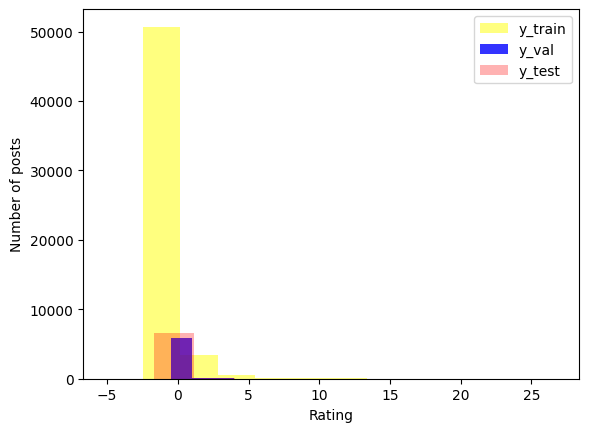

In [49]:
plt.hist(y_train_scale, color='yellow', alpha=0.5, label='y_train', bins=10)
plt.hist(y_val_scale, color='blue', alpha=0.8, label='y_val', bins=10)
plt.hist(y_test_scale, color='red', alpha=0.3, label='y_test', bins=10)
plt.xlabel('Rating')
plt.ylabel('Number of posts')
plt.legend()

### Model Linear Regression

In [12]:
regr_model = LinearRegression().fit(X_train_vector, y_train_scale)

In [14]:
regr_model.score(X_val_vector, y_val_scale)

0.016608689725936654

In [19]:
r2 = regr_model.score(X_test_vector, y_test_scale)
y_pred = regr_model.predict(X_test_vector)
rmse = MSE(y_test_scale, y_pred)**0.5

In [21]:
index = ['LinearRegression']
data_table = {'RMSE': [rmse],
              'R^2': [r2]}

df_metrics = pd.DataFrame(data_table, index=index)
print(df_metrics)

                      RMSE       R^2
LinearRegression  1.090341  0.013332
